## Imports

In [18]:
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import time
import memory_profiler
import tensorflow as tf
import numpy as np
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Conv2D, AveragePooling2D
from tensorflow.keras.models import Model, Sequential

In [19]:
# Завантаження даних
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
# Нормалізація даних
# x_train = tf.keras.utils.normalize(x_train, axis=1)
# x_test = tf.keras.utils.normalize(x_test, axis=1)

# Нормалізація
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# reshape
x_train_flat = x_train.reshape((len(x_train), 784))
x_test_flat = x_test.reshape((len(x_test), 784))


In [20]:
x_train_flat.shape

(60000, 784)

## Pipeline

In [21]:
# SVD
svd = TruncatedSVD(n_components=729)

def svd_fit():
    svd.fit(x_train_flat)

start_time = time.time()
svd_fit()
svd_train_time = time.time() - start_time

x_train_flat_cut = svd.transform(x_train_flat)
x_train_flat_cut.shape

(60000, 729)

In [22]:
# AE
latent_dim = 64
inputs = Input(shape=(784,))
encoded = Dense(128, activation='relu')(inputs)
encoded = Dense(latent_dim, activation='relu')(encoded)
decoded = Dense(128, activation='relu')(encoded)
decoded = Dense(729, activation='sigmoid')(decoded)
# outputs = Reshape((28, 28))(decoded)

autoencoder = tf.keras.Model(inputs, decoded)
autoencoder.compile(optimizer='adam', loss='mse')

def ae_fit():
    autoencoder.fit(x_train_flat, x_train_flat_cut, epochs=10)

start_time = time.time()
ae_fit()
AE_train_time = time.time() - start_time

x_train_flat_cut = autoencoder.predict(x_train_flat)
print(x_train_flat_cut.shape)
x_test_flat_cut = autoencoder.predict(x_test_flat)

Epoch 1/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.1018
Epoch 2/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0926
Epoch 3/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0893
Epoch 4/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0882
Epoch 5/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0875
Epoch 6/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0870
Epoch 7/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0867
Epoch 8/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0864
Epoch 9/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0862
Epoch 10/10
1875/1875 [==============================] - 2s 1ms/step
(60000, 729)
313/313 [==============================] - 0s 994us/step


In [23]:
# SVD
svd = TruncatedSVD(n_components=676)

def svd_fit():
    svd.fit(x_train_flat_cut)

start_time = time.time()
svd_fit()
svd_train_time = time.time() - start_time

x_train_transformed = svd.transform(x_train_flat_cut)
print(x_train_transformed.shape)
x_test_transformed = svd.transform(x_test_flat_cut)

(60000, 676)


In [24]:
x_train_reduced = np.reshape(x_train_transformed, (len(x_train_transformed), 26, 26))
x_test_reduced = np.reshape(x_test_transformed, (len(x_test_transformed), 26, 26))
x_train_reduced.shape

(60000, 26, 26)

## evaluation on model LeNet-5

In [25]:
# Перетворюємо цілочисельні мітки на одне-гаряче кодування
y_train_cat = tf.keras.utils.to_categorical(y_train, num_classes=10)
y_test_cat = tf.keras.utils.to_categorical(y_test, num_classes=10)

### build and train model on original data

In [26]:
def foo_model1():
    # Додаємо канал кольору
    x_train_mod = tf.expand_dims(x_train, axis=-1)
    x_test_mod = tf.expand_dims(x_test, axis=-1)

    model = Sequential()

    # Перший згортковий блок
    model.add(Conv2D(6, kernel_size=(5, 5), strides=(1, 1), activation='tanh', input_shape=(28,28,1), padding='same'))
    model.add(AveragePooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid'))

    # Другий згортковий блок
    model.add(Conv2D(16, kernel_size=(5, 5), strides=(1, 1), activation='tanh', padding='valid'))
    model.add(AveragePooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid'))

    # Повнозв'язні шари
    model.add(Flatten())
    model.add(Dense(120, activation='tanh'))
    model.add(Dense(84, activation='tanh'))
    model.add(Dense(10, activation='softmax'))

    # Компіляція моделі
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    history = model.fit(x_train_mod, y_train_cat, batch_size=32, epochs=10, validation_data=(x_test_mod, y_test_cat))
    
    return model, history, x_test_mod

### build and train model on reduced data

In [27]:
def foo_model2():
    # Додаємо канал кольору
    x_train_reduced_mod = tf.expand_dims(x_train_reduced, axis=-1)
    x_test_reduced_mod = tf.expand_dims(x_test_reduced, axis=-1)

    model2 = Sequential()

    # Перший згортковий блок
    model2.add(Conv2D(6, kernel_size=(5, 5), strides=(1, 1), activation='tanh', input_shape=(26,26,1), padding='same'))
    model2.add(AveragePooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid'))

    # Другий згортковий блок
    model2.add(Conv2D(16, kernel_size=(5, 5), strides=(1, 1), activation='tanh', padding='valid'))
    model2.add(AveragePooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid'))

    # Повнозв'язні шари
    model2.add(Flatten())
    model2.add(Dense(120, activation='tanh'))
    model2.add(Dense(84, activation='tanh'))
    model2.add(Dense(10, activation='softmax'))

    # Компіляція моделі
    model2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    history2 = model2.fit(x_train_reduced_mod, y_train_cat, batch_size=32, epochs=10, validation_data=(x_test_reduced_mod, y_test_cat))
    
    return model2, history2, x_test_reduced_mod

### Performance evaluation

In [28]:
start_time = time.time()
model, history, x_test_mod = foo_model1()
end_time1 = time.time() - start_time

Epoch 1/10
1875/1875 [==============================] - 7s 3ms/step - loss: 0.2335 - accuracy: 0.9307 - val_loss: 0.1056 - val_accuracy: 0.9662
Epoch 2/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0937 - accuracy: 0.9709 - val_loss: 0.0706 - val_accuracy: 0.9776
Epoch 3/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0631 - accuracy: 0.9804 - val_loss: 0.0666 - val_accuracy: 0.9799
Epoch 4/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0473 - accuracy: 0.9849 - val_loss: 0.0512 - val_accuracy: 0.9842
Epoch 5/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0382 - accuracy: 0.9880 - val_loss: 0.0558 - val_accuracy: 0.9819
Epoch 6/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0312 - accuracy: 0.9902 - val_loss: 0.0518 - val_accuracy: 0.9826
Epoch 7/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0260 - accuracy: 0.9917 - val_loss: 0.0479 - val_accuracy:

In [29]:
print(f"Час навчання LENet на оригінальних даних - {end_time1}")

Час навчання LENet на оригінальних даних - 63.0263090133667


In [30]:
start_time = time.time()
model2, history2, x_test_reduced_mod = foo_model2()
end_time2 = time.time() - start_time

Epoch 1/10
1875/1875 [==============================] - 7s 3ms/step - loss: 1.2024 - accuracy: 0.5979 - val_loss: 0.7918 - val_accuracy: 0.7521
Epoch 2/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.7562 - accuracy: 0.7642 - val_loss: 0.7032 - val_accuracy: 0.7827
Epoch 3/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.6880 - accuracy: 0.7872 - val_loss: 0.6459 - val_accuracy: 0.8029
Epoch 4/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.6358 - accuracy: 0.8033 - val_loss: 0.6132 - val_accuracy: 0.8112
Epoch 5/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.5854 - accuracy: 0.8196 - val_loss: 0.5537 - val_accuracy: 0.8301
Epoch 6/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.5339 - accuracy: 0.8360 - val_loss: 0.5165 - val_accuracy: 0.8401
Epoch 7/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.4888 - accuracy: 0.8480 - val_loss: 0.4724 - val_accuracy:

In [31]:
print(f"Час навчання LENet на редукованих даних - {end_time2}")

Час навчання LENet на редукованих даних - 59.24518656730652


  1/313 [..............................] - ETA: 6s - loss: 0.0080 - accuracy: 1.0000

313/313 [==============================] - 1s 2ms/step - loss: 0.3897 - accuracy: 0.8825
Оцінка моделей оригінальні\редуковані дані 0.5819990634918213\0.5543680191040039 секунд
Точність: 0.9865999817848206\0.8824999928474426
Втрати: 0.045390766113996506\0.3896706998348236
313/313 [==============================] - 1s 1ms/step
Класифікаційний звіт для оригінальних даних:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       980
           1       0.99      1.00      0.99      1135
           2       0.99      0.99      0.99      1032
           3       0.98      1.00      0.99      1010
           4       0.99      0.99      0.99       982
           5       0.99      0.98      0.98       892
           6       0.99      0.99      0.99       958
           7       0.99      0.98      0.98      1028
           8       0.99      0.98      0.99       974
           9       0.97      0.98      0.98      1009

    accuracy                   

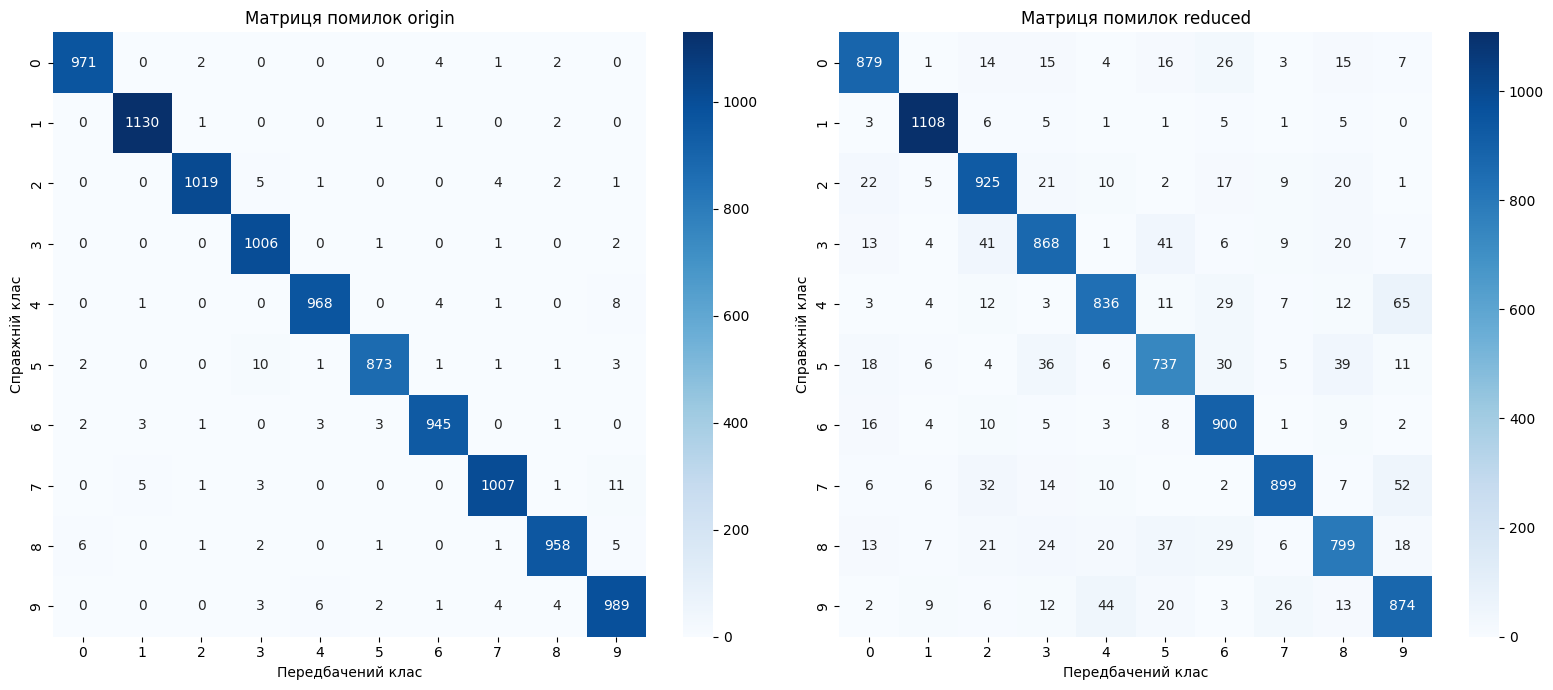

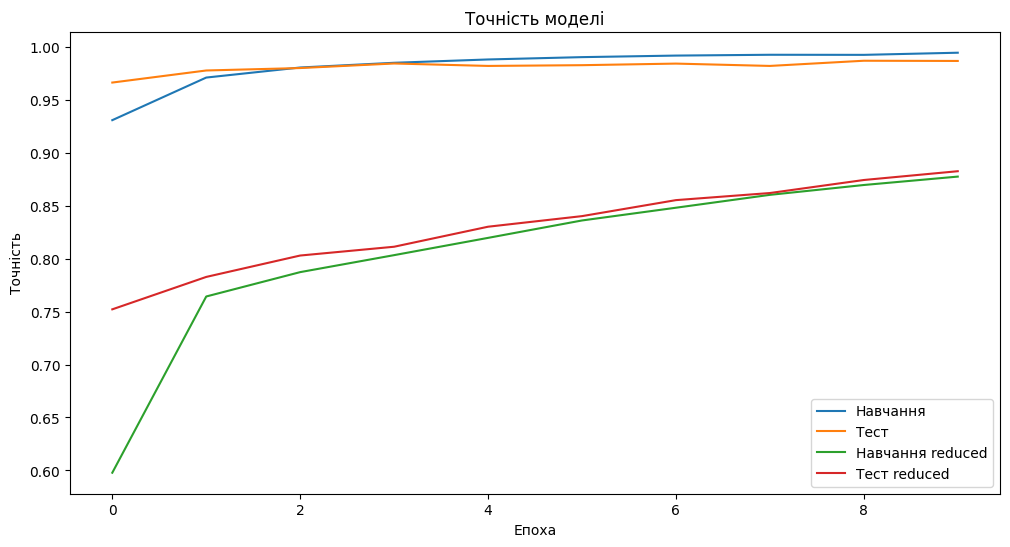

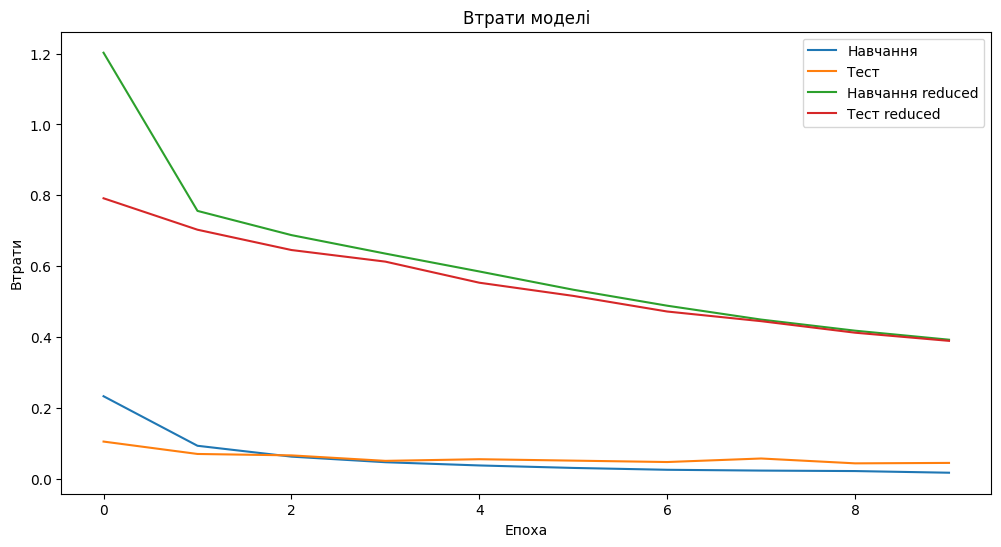

In [32]:
# Оцінка моделі
start_time = time.time()
loss, accuracy = model.evaluate(x_test_mod, y_test_cat)
time1 = time.time() - start_time

start_time = time.time()
loss2, accuracy2 = model2.evaluate(x_test_reduced_mod, y_test_cat)
time2 = time.time() - start_time

print(f"Оцінка моделей оригінальні\редуковані дані {time1}\{time2} секунд")
print(f"Точність: {accuracy}\{accuracy2}")
print(f"Втрати: {loss}\{loss2}")

# Передбачення моделі
y_pred = model.predict(x_test_mod)
y_pred_classes = np.argmax(y_pred, axis=1)

y_pred2 = model2.predict(x_test_reduced_mod)
y_pred_classes2 = np.argmax(y_pred2, axis=1)

# Виведення декількох метрик
print("Класифікаційний звіт для оригінальних даних:")
print(classification_report(y_test, y_pred_classes))
print("Класифікаційний звіт для редукованих даних:")
print(classification_report(y_test, y_pred_classes2))

# confusion_matrix
cm = confusion_matrix(y_test, y_pred_classes)
cm2 = confusion_matrix(y_test, y_pred_classes2)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax1)
ax1.set_title('Матриця помилок origin')
ax1.set_xlabel('Передбачений клас')
ax1.set_ylabel('Справжній клас')

sns.heatmap(cm2, annot=True, fmt='d', cmap='Blues', ax=ax2)
ax2.set_title('Матриця помилок reduced')
ax2.set_xlabel('Передбачений клас')
ax2.set_ylabel('Справжній клас')
plt.tight_layout()
plt.show()

# Побудова графіка точності
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.title('Точність моделі')
plt.ylabel('Точність')
plt.xlabel('Епоха')
plt.legend(['Навчання', 'Тест', 'Навчання reduced', 'Тест reduced'], loc='best')
plt.show()

# Побудова графіка втрат
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('Втрати моделі')
plt.ylabel('Втрати')
plt.xlabel('Епоха')
plt.legend(['Навчання', 'Тест', 'Навчання reduced', 'Тест reduced'], loc='upper right')
plt.show()

Epoch 1/10
1875/1875 [==============================] - 7s 3ms/step - loss: 0.2265 - accuracy: 0.9327 - val_loss: 0.1014 - val_accuracy: 0.9675
Epoch 2/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0910 - accuracy: 0.9715 - val_loss: 0.0744 - val_accuracy: 0.9772
Epoch 3/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0625 - accuracy: 0.9801 - val_loss: 0.0679 - val_accuracy: 0.9787
Epoch 4/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0468 - accuracy: 0.9858 - val_loss: 0.0556 - val_accuracy: 0.9828
Epoch 5/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0372 - accuracy: 0.9882 - val_loss: 0.0545 - val_accuracy: 0.9833
Epoch 6/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0303 - accuracy: 0.9905 - val_loss: 0.0497 - val_accuracy: 0.9850
Epoch 7/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0264 - accuracy: 0.9917 - val_loss: 0.0457 - val_accuracy:

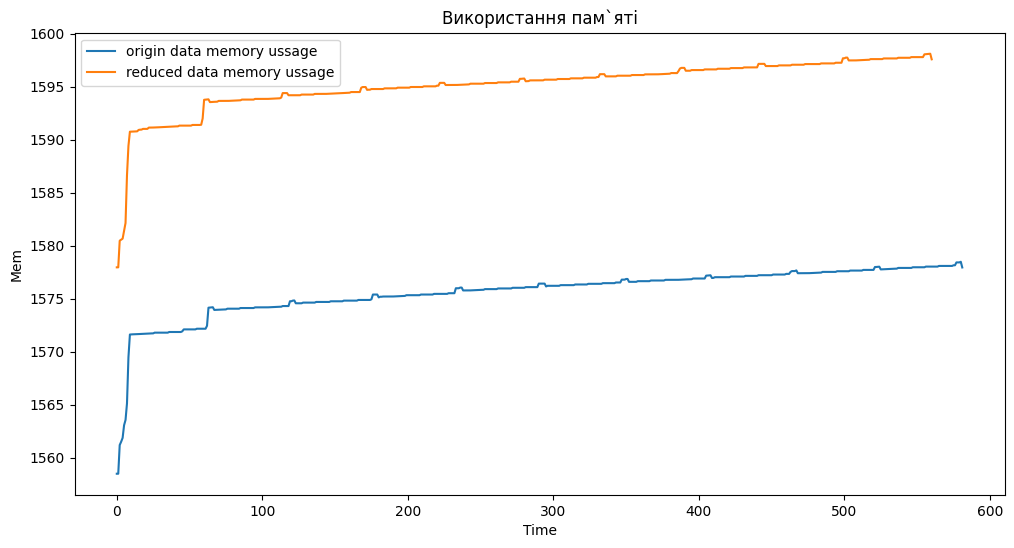

In [35]:
mem_res1 = memory_profiler.memory_usage(foo_model1)
mem_res2 = memory_profiler.memory_usage(foo_model2)

plt.figure(figsize=(12, 6))
plt.plot(mem_res1)
plt.plot(mem_res2)
plt.title('Використання пам`яті')
plt.ylabel('Mem')
plt.xlabel('Time')
plt.legend(['origin data memory ussage', 'reduced data memory ussage'])
plt.show()

In [34]:
print("AE train time:", AE_train_time)
print("SVD train time:", svd_train_time)

AE train time: 35.87047719955444
SVD train time: 10.176604747772217


TODO read:
https://www.kaggle.com/code/jonathankristanto/experimenting-with-pca-on-mnist-dataset